# EE 467 Lab 2 (Extension): Breaking CAPTCHAs with **PyTorch**

This notebook is the PyTorch reimplementation of the TensorFlow/Keras CNN from the lab.

**Deliverable:** `Breaking-CAPTCHAS-Pytorch.ipynb`

What this notebook does:
- Loads the same CAPTCHA dataset.
- Extracts character crops (20×20 grayscale) and builds a per-character classifier.
- Trains a CNN in **PyTorch** with a structure matching the Keras model:
  - Conv(20, 5×5, same) → ReLU → MaxPool(2×2)
  - Conv(50, 5×5, same) → ReLU → MaxPool(2×2)
  - Flatten → FC(500) → FC(n_classes)
- Evaluates on the held-out test CAPTCHAs.

Minor accuracy differences vs TensorFlow are expected due to randomness and implementation details.

In [1]:
# Install dependencies.

%pip install -q matplotlib scikit-learn "opencv-python>4" imutils
%pip install -q "torch>=2" "torchvision>=0.16"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, pickle
from pprint import pprint

import cv2
import numpy as np
import imutils
from imutils import paths

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

from lab_2_helpers import *  # resize_to_fit, print_images, group_every, unzip, etc.

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Torch: 2.4.1+cu124
CUDA available: True


In [3]:
# Unpack the dataset (same as the TensorFlow notebook)
!tar -xJf captcha-images.tar.xz

CAPTCHA_IMAGE_FOLDER = "./captcha-images"
captcha_image_paths = list(paths.list_images(CAPTCHA_IMAGE_FOLDER))
print("Num CAPTCHA images:", len(captcha_image_paths))
pprint(captcha_image_paths[:10])

Num CAPTCHA images: 2272
['./captcha-images\\2A2X.png',
 './captcha-images\\2A5R.png',
 './captcha-images\\2A5Z.png',
 './captcha-images\\2A98.png',
 './captcha-images\\2A9N.png',
 './captcha-images\\2AD9.png',
 './captcha-images\\2AEF.png',
 './captcha-images\\2APC.png',
 './captcha-images\\2AQ7.png',
 './captcha-images\\2AX2.png']


In [4]:
def extract_captcha_text(image_path):
    image_file_name = os.path.basename(image_path)
    return os.path.splitext(image_file_name)[0]

captcha_texts = [extract_captcha_text(p) for p in captcha_image_paths]
pprint(captcha_texts[:10])

['2A2X', '2A5R', '2A5Z', '2A98', '2A9N', '2AD9', '2AEF', '2APC', '2AQ7', '2AX2']


Figure(2000x500)


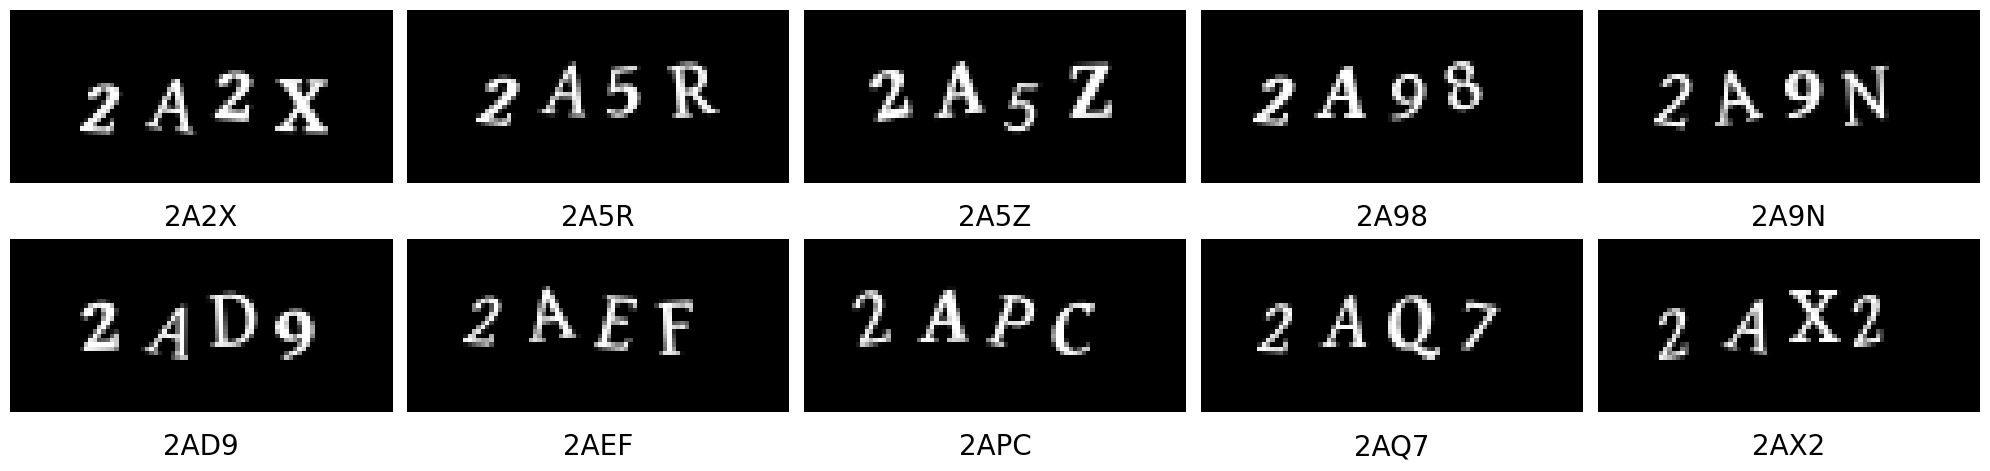

In [6]:
def load_transform_image(image_path):
    """Load and transform CAPTCHA image into grayscale with padding."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Padding
    image_padded = cv2.copyMakeBorder(image, 8, 8, 8, 8, cv2.BORDER_CONSTANT, value=(255, 255, 255))
    return image_padded

captcha_images = [load_transform_image(p) for p in captcha_image_paths]

print_images(
    captcha_images[:10], n_rows=2, texts=captcha_texts[:10]
)

In [7]:
# Train-validation-test split seed (same as TensorFlow notebook)
TVT_SPLIT_SEED = 31528476

captcha_images_tv, captcha_images_test, captcha_texts_tv, captcha_texts_test = train_test_split(
    captcha_images, captcha_texts, test_size=0.2, random_state=TVT_SPLIT_SEED
)

print("Train-validation:", len(captcha_texts_tv))
print("Test:", len(captcha_texts_test))

Train-validation: 1817
Test: 455


In [8]:
# Character images folder template (same naming)
CHAR_IMAGE_FOLDER = f"./char-images-{TVT_SPLIT_SEED}"
LABELS_PATH = "./labels.pkl"

def extract_chars(image):
    """Find contours and extract characters inside each CAPTCHA."""
    # Threshold to binary (white background -> black; characters -> white)
    image_bw = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # OPTIONAL: if you often get <4 contours due to merged characters,
    # uncomment the morphology below to help split characters.
    # k = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    # image_bw = cv2.morphologyEx(image_bw, cv2.MORPH_OPEN, k, iterations=1)
    # image_bw = cv2.erode(image_bw, k, iterations=1)

    contours = cv2.findContours(image_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    char_regions = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        # Heuristic: if region is too wide, assume it contains 2 characters and split
        if w / h > 1.25:
            half_width = int(w / 2)
            char_regions.append((x, y, half_width, h))
            char_regions.append((x + half_width, y, w - half_width, h))
        else:
            char_regions.append((x, y, w, h))

    # Must be exactly 4 for this dataset
    if len(char_regions) != 4:
        return None

    char_regions.sort(key=lambda x: x[0])

    char_images = []
    for x, y, w, h in char_regions:
        char_image = image[y - 2:y + h + 2, x - 2:x + w + 2]
        char_images.append(char_image)

    return char_images

def save_chars(char_images, captcha_text, save_dir, char_counts):
    """Save character crops into per-label folders."""
    for char_image, char in zip(char_images, captcha_text):
        save_path = os.path.join(save_dir, char)
        os.makedirs(save_path, exist_ok=True)

        char_count = char_counts.get(char, 1)
        char_image_path = os.path.join(save_path, f"{char_count}.png")
        cv2.imwrite(char_image_path, char_image)

        char_counts[char] = char_count + 1

FORCE_EXTRACT_CHAR = False

# Extract and save images for characters (if not already available)
char_counts = {}
if FORCE_EXTRACT_CHAR or not os.path.exists(CHAR_IMAGE_FOLDER):
    for captcha_image, captcha_text in zip(captcha_images_tv, captcha_texts_tv):
        char_images = extract_chars(captcha_image)
        if char_images is None:
            continue
        save_chars(char_images, captcha_text, CHAR_IMAGE_FOLDER, char_counts)

print("Char image folder exists:", os.path.exists(CHAR_IMAGE_FOLDER))
print("Num char images:", len(list(paths.list_images(CHAR_IMAGE_FOLDER))))

Char image folder exists: True
Num char images: 7148


In [9]:
def make_feature(image):
    """Resize character to 20×20 and add channel dimension."""
    image_resized = resize_to_fit(image, 20, 20)
    feature = image_resized[..., None]  # (20, 20, 1)
    return feature

def make_feature_label(image_path):
    feature = make_feature(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE))
    label = image_path.split(os.path.sep)[-2]
    return feature, label

# Build features and labels from extracted character crops
features_tv, labels_tv = unzip((
    make_feature_label(p) for p in paths.list_images(CHAR_IMAGE_FOLDER)
))

# Scale to [0, 1]
features_tv = np.array(features_tv, dtype=np.float32) / 255.0

# Map labels to indices (CrossEntropyLoss wants integer class indices)
lb = LabelBinarizer()
_ = lb.fit_transform(labels_tv)
classes = list(lb.classes_)
n_classes = len(classes)
class_to_idx = {c: i for i, c in enumerate(classes)}
y_idx_tv = np.array([class_to_idx[c] for c in labels_tv], dtype=np.int64)

# Save label binarizer for decoding predictions later
with open(LABELS_PATH, "wb") as f:
    pickle.dump(lb, f)

print("n_classes:", n_classes)
print("classes sample:", classes[:10])

n_classes: 32
classes sample: ['2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B']


In [10]:
# Split into train/validation (same proportions as TF notebook)
X_train, X_vali, y_train, y_vali = train_test_split(
    features_tv, y_idx_tv, test_size=0.25, random_state=955996
)

print("Train:", len(X_train), "Val:", len(X_vali))

Train: 5361 Val: 1787


In [11]:
class CharDataset(Dataset):
    def __init__(self, X, y):
        # X: (N, 20, 20, 1) float32 in [0,1]
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]                      # (20,20,1)
        x = np.transpose(x, (2, 0, 1))        # -> (1,20,20) for PyTorch
        x = torch.from_numpy(x).float()
        y = torch.tensor(self.y[idx]).long()
        return x, y

BATCH_SIZE = 32
train_loader = DataLoader(CharDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
vali_loader  = DataLoader(CharDataset(X_vali, y_vali),   batch_size=BATCH_SIZE, shuffle=False)

In [12]:
# PyTorch CNN mirroring the Keras model:
# Conv2D(20, 5×5, padding='same') -> ReLU -> MaxPool2D(2×2)
# Conv2D(50, 5×5, padding='same') -> ReLU -> MaxPool2D(2×2)
# Flatten -> Dense(500) -> Dense(n_classes)

class CaptchaCNN(nn.Module):
    def __init__(self, n_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(20, 50, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(50 * 5 * 5, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, n_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CaptchaCNN(n_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(model)

CaptchaCNN(
  (features): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1250, out_features=500, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=500, out_features=32, bias=True)
  )
)


In [13]:
# Train
N_EPOCHS = 10
MODEL_WEIGHTS_PATH = "./captcha-model.pth"
FORCE_TRAINING = True

def run_epoch(loader, training: bool):
    if training:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_correct = 0
    total = 0

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        if training:
            optimizer.zero_grad()

        with torch.set_grad_enabled(training):
            logits = model(xb)
            loss = criterion(logits, yb)

            if training:
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == yb).sum().item()
        total += xb.size(0)

    return total_loss / total, total_correct / total

if FORCE_TRAINING or not os.path.exists(MODEL_WEIGHTS_PATH):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(1, N_EPOCHS + 1):
        tr_loss, tr_acc = run_epoch(train_loader, training=True)
        va_loss, va_acc = run_epoch(vali_loader, training=False)

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss)
        history["val_acc"].append(va_acc)

        print(f"Epoch {epoch:02d}/{N_EPOCHS} | "
              f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
              f"val loss {va_loss:.4f} acc {va_acc:.4f}")

    torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
else:
    model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=device))
    model.eval()
    history = None

print("Saved weights:", os.path.exists(MODEL_WEIGHTS_PATH))

Epoch 01/10 | train loss 1.3408 acc 0.6476 | val loss 0.1326 acc 0.9787
Epoch 02/10 | train loss 0.0806 acc 0.9838 | val loss 0.0565 acc 0.9899
Epoch 03/10 | train loss 0.0309 acc 0.9938 | val loss 0.0511 acc 0.9922
Epoch 04/10 | train loss 0.0131 acc 0.9974 | val loss 0.0370 acc 0.9950
Epoch 05/10 | train loss 0.0053 acc 0.9991 | val loss 0.0313 acc 0.9938
Epoch 06/10 | train loss 0.0032 acc 0.9993 | val loss 0.0393 acc 0.9955
Epoch 07/10 | train loss 0.0014 acc 0.9994 | val loss 0.0361 acc 0.9955
Epoch 08/10 | train loss 0.0010 acc 0.9998 | val loss 0.0290 acc 0.9955
Epoch 09/10 | train loss 0.0012 acc 0.9998 | val loss 0.0412 acc 0.9955
Epoch 10/10 | train loss 0.0002 acc 1.0000 | val loss 0.0402 acc 0.9955
Saved weights: True


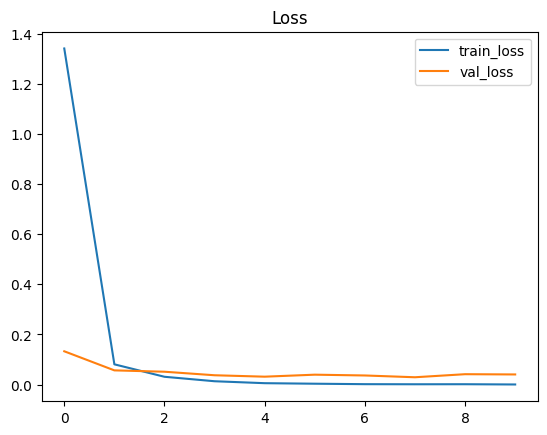

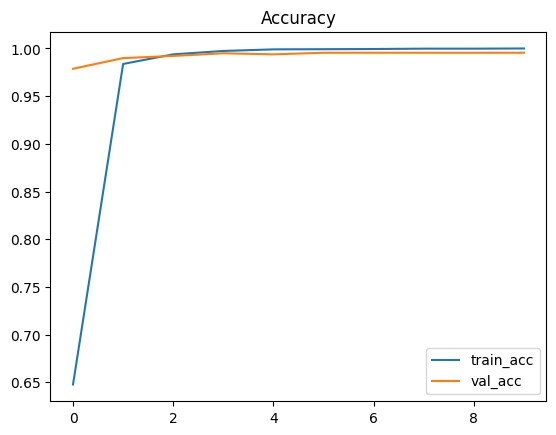

In [14]:
# Optional: plot training curves
if history is not None:
    plt.figure()
    plt.plot(history["train_loss"], label="train_loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

    plt.figure()
    plt.plot(history["train_acc"], label="train_acc")
    plt.plot(history["val_acc"], label="val_acc")
    plt.legend()
    plt.title("Accuracy")
    plt.show()

In [15]:
# Evaluate on held-out CAPTCHA test set (same logic as TF notebook)
with open(LABELS_PATH, "rb") as f:
    lb = pickle.load(f)
classes = list(lb.classes_)
idx_to_class = {i: c for i, c in enumerate(classes)}

DUMMY_CHAR_IMAGES = np.zeros((4, 20, 20, 1), dtype=np.float32)

extract_failed_indices = []
char_images_test = []

for i, captcha_image in enumerate(captcha_images_test):
    chars = extract_chars(captcha_image)
    if chars:
        char_images_test.extend(chars)
    else:
        extract_failed_indices.append(i)
        char_images_test.extend(DUMMY_CHAR_IMAGES)

features_test = [make_feature(ci) for ci in char_images_test]
features_test = np.array(features_test, dtype=np.float32) / 255.0

# Run model
model.eval()
all_preds = []
with torch.no_grad():
    # batch for speed
    X = torch.from_numpy(np.transpose(features_test, (0, 3, 1, 2))).float().to(device)  # (N,1,20,20)
    logits = model(X)
    pred_idx = logits.argmax(dim=1).cpu().numpy()
    all_preds = [idx_to_class[int(i)] for i in pred_idx]

preds_test = ["".join(chars) for chars in group_every(all_preds, 4)]
for i in extract_failed_indices:
    preds_test[i] = "-"

# Compute accuracy on CAPTCHAs where extraction succeeded
n_test = len(captcha_texts_test)
n_correct = 0
for pred_text, actual_text in zip(preds_test, captcha_texts_test):
    if pred_text == actual_text:
        n_correct += 1

print("# of test CAPTCHAs:", n_test)
print("# correctly recognized:", n_correct)
print("Accuracy:", n_correct / n_test)
print("Extraction failed on:", len(extract_failed_indices), "CAPTCHAs")

# of test CAPTCHAs: 455
# correctly recognized: 445
Accuracy: 0.978021978021978
Extraction failed on: 8 CAPTCHAs


Figure(2000x500)
Figure(2000x600)


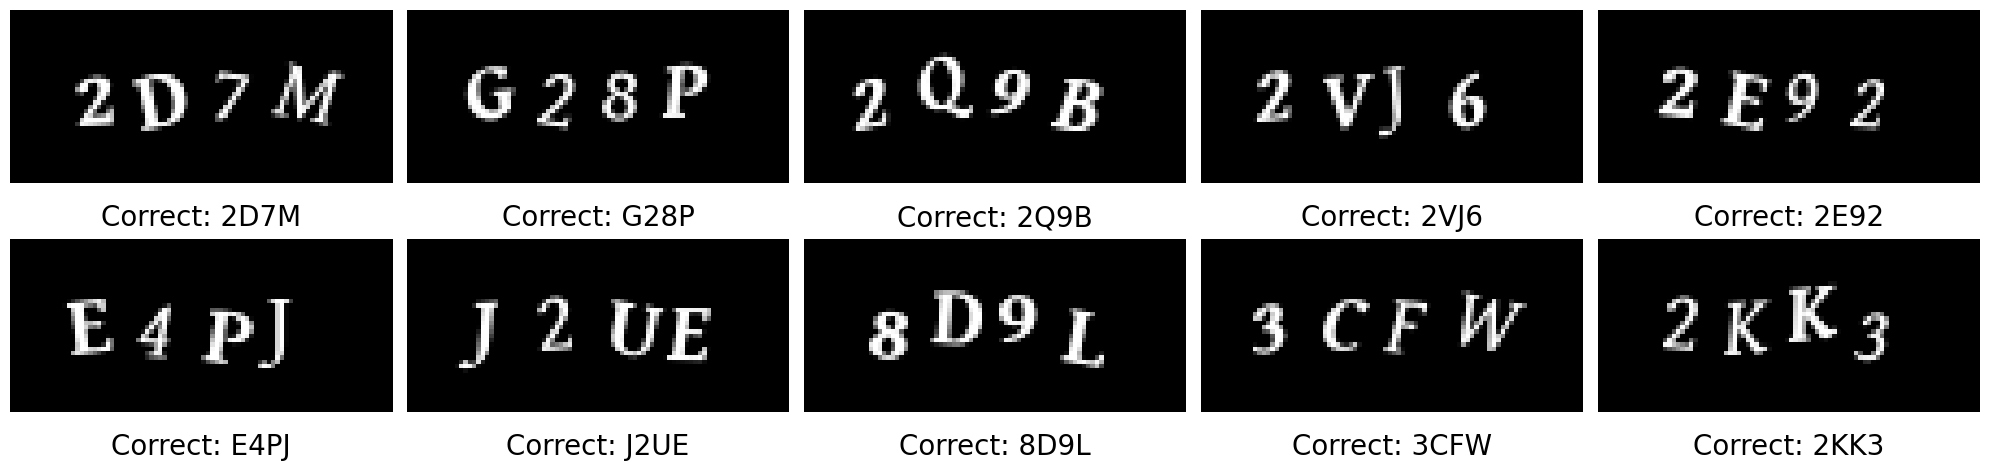

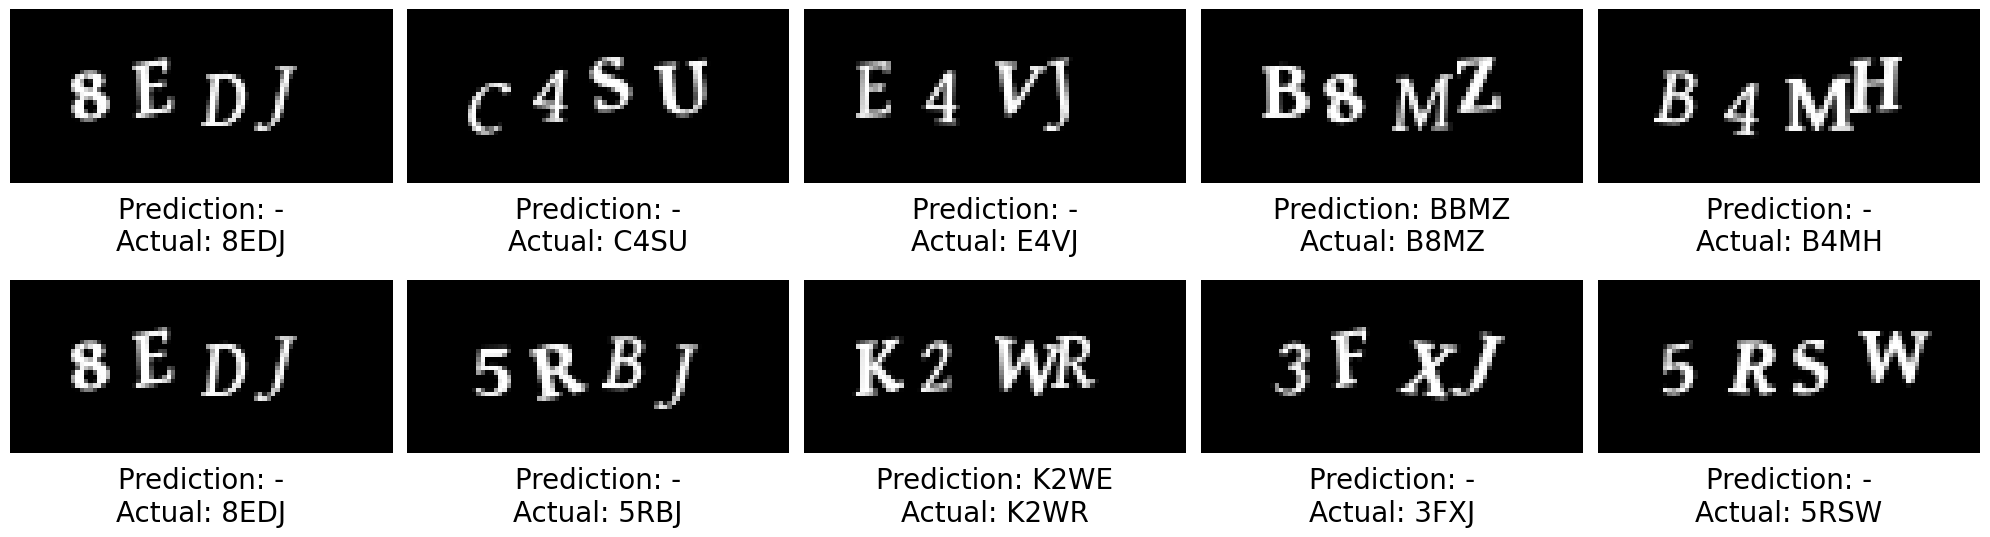

In [16]:
# Display a few correct / incorrect predictions (same as TF notebook)
N_DISPLAY_SAMPLES = 10

correct_indices = []
incorrect_indices = []

for i, (pred_text, actual_text) in enumerate(zip(preds_test, captcha_texts_test)):
    if pred_text == actual_text and len(correct_indices) < N_DISPLAY_SAMPLES:
        correct_indices.append(i)
    elif pred_text != actual_text and len(incorrect_indices) < N_DISPLAY_SAMPLES:
        incorrect_indices.append(i)

print_images(
    [captcha_images_test[i] for i in correct_indices],
    texts=[f"Correct: {captcha_texts_test[i]}" for i in correct_indices],
    n_rows=2
)

print_images(
    [captcha_images_test[i] for i in incorrect_indices],
    texts=[f"Prediction: {preds_test[i]}\nActual: {captcha_texts_test[i]}" for i in incorrect_indices],
    n_rows=2,
    fig_size=(20, 6),
    text_center=(0.5, -0.25)
)

## Notes / Differences vs TensorFlow

- **Loss:** PyTorch uses `CrossEntropyLoss`, which expects integer class indices (not one-hot).  
- **Input shape:** PyTorch expects `N×C×H×W` while Keras uses `N×H×W×C`.  
- Minor result differences are normal due to random initialization / shuffling.